In [71]:
import numpy as np
import pandas as pd
import seaborn as sns

# Simple example of bootstrap estimates
First create two populations for each study

In [72]:
n_A = 11037
n_B = 11034

heart_attack_A = np.zeros(n_A)
heart_attack_A[:104] = 1
heart_attack_B = np.zeros(n_B)
heart_attack_B[:189] = 1

stroke_A = np.zeros(n_A)
stroke_A[:119] = 1
stroke_B = np.zeros(n_B)
stroke_B[:98] = 1

Let's deal with the heart attack data first. Create B bootstrap samples and calculate our statistic:

In [73]:
B = 1000
T_h = np.zeros(B)

for i in range(B):
    h_A = np.random.choice(heart_attack_A,n_A) # bootstrap sample A
    h_B = np.random.choice(heart_attack_B,n_B) # bootstrap sample B
    T_h[i] = np.average(h_A) / np.average(h_B) # ratio of rates

And repeat for the stroke data

In [74]:
T_s = np.zeros(B)

for i in range(B):
    s_A = np.random.choice(stroke_A,n_A)
    s_B = np.random.choice(stroke_B,n_B)
    T_s[i] = np.average(s_A) / np.average(s_B)

Now let's look at some summary statistics of our bootstrap replicates:

In [75]:
df = pd.DataFrame({'heart attacks': T_h, 'strokes': T_s})
df.describe()

,heart attacks,strokes
count,1000.000000,1000.000000
mean,0.551805,1.228141
std,0.066109,0.170869
min,0.374898,0.794866
25%,0.507634,1.107043
50%,0.547419,1.210197
75%,0.594925,1.332971
max,0.764498,1.858650


Often we might be more interested in the 95% percentile interval:

In [76]:
print('Approximate 95 percentile interval for heart attack ratio of rates: (%f, %f)' % (np.percentile(T_h, 2.5), np.percentile(T_h, 97.5)))
print('Approximate 95 percentile interval for stroke ratio of rates: (%f, %f)' % (np.percentile(T_s, 2.5), np.percentile(T_s, 97.5)))

Approximate 95 percentile interval for heart attack ratio of rates: (0.428439, 0.694454)
Approximate 95 percentile interval for stroke ratio of rates: (0.931775, 1.585826)


Now let's look at the confidence intervals:

In [77]:
ts_h = (104/11037) / (189/11034)
ts_s = (119/11037) / (98/11034)
alpha = 5

q95_h = (ts_h - np.percentile(T_h - ts_h, 100-alpha/2), ts_h - np.percentile(T_h - ts_h, alpha/2))
q95_s = (ts_s - np.percentile(T_s - ts_s, 100-alpha/2), ts_s - np.percentile(T_s - ts_s, alpha/2))

print('CI95 for heart attack ratio of rates: (%f, %f)' % (q95_h[0], q95_h[1]))
print('CI95 for stroke ratio of rates: (%f, %f)' % (q95_s[0], q95_s[1]))

CI95 for heart attack ratio of rates: (0.405776, 0.671791)
CI95 for stroke ratio of rates: (0.842085, 1.496136)


# More complicated example with polynomial regression
Let's start by defining a polynomial function, $y = \beta_0 + \beta_1x + \beta_2x^2 + \epsilon$, and sampling some data

<Axes: >

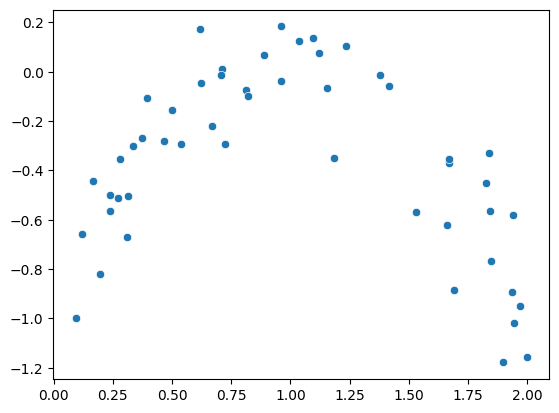

In [78]:
beta = [-1, 2, -1]
model = np.poly1d(beta)

x = np.random.random(50)*2
y = model(x) + np.random.randn(50)*.2

sns.scatterplot(x=x,y=y)

We can fit a polynomial regression:

In [79]:
fit = np.polyfit(x,y,2)
fit

array([-1.01897208,  2.00862369, -0.96213849])

Our estimate is that the maximum occurs at $\hat{\theta} = -\frac{\hat{\beta_1}}{2\hat{\beta_2}}$ (and we know the maximum should be at 1)

In [80]:
theta_hat = -fit[1]/(2*fit[2])
theta_hat

np.float64(1.0438329376810236)

Now generate bootstrap samples of the data, polynomial fits of each sample, and bootstrap replicates of the estimated maximum:

In [81]:
B = 1000
n = len(x)
T = np.zeros(B)

for i in range(B):
    idx = np.random.choice(n,n)
    xi = x[idx]
    yi = y[idx]
    fit_i = np.polyfit(xi,yi,2)
    t = -fit_i[1]/(2*fit_i[2])
    T[i] = t

Finally, the bootstrap confidence interval:

In [82]:
alpha = 5

q95 = (theta_hat - np.percentile(T - theta_hat, 100-alpha/2), theta_hat - np.percentile(T - theta_hat, alpha/2))
q95

(np.float64(0.9706411583105583), np.float64(1.1278817000304602))

In [83]:
(np.percentile(T,2.5), np.percentile(T,97.5))

(np.float64(0.9597841753315871), np.float64(1.1170247170514889))

# High dimensional bootstrap
Let's say we're interested in a confidence set for a high dimensional covariance matrix (...well, maybe not so high dimensional)

In [84]:
mu = [0,0,0]
sigma = np.array([[1,0,.5],[0,2,.1],[.5,.1,1]])
X = np.random.multivariate_normal(mu,sigma,100)
X.shape

(100, 3)

In [85]:
theta_hat = np.cov(X.T)
theta_hat

array([[0.86169405, 0.16714433, 0.56166515],
       [0.16714433, 1.83117404, 0.16865598],
       [0.56166515, 0.16865598, 1.10314082]])

In [86]:
B = 1000
n = X.shape[0]
T = np.zeros((B,X.shape[1],X.shape[1]))

for i in range(B):
    idx = np.random.choice(n,n)
    Xi = X[idx]
    t = np.cov(Xi.T)
    T[i] = t

In [87]:
q = abs(T - theta_hat).max(axis=(1,2))
q95 = np.percentile(q,95)
print(q95)
q95_low = theta_hat - q95
q95_high = theta_hat + q95

0.4969272703008564


In [88]:
q95_low

array([[ 0.36476678, -0.32978294,  0.06473788],
       [-0.32978294,  1.33424676, -0.32827129],
       [ 0.06473788, -0.32827129,  0.60621355]])

In [89]:
q95_high

array([[1.35862132, 0.6640716 , 1.05859242],
       [0.6640716 , 2.32810131, 0.66558325],
       [1.05859242, 0.66558325, 1.60006809]])